# CryoDRGN interactive filtering

This jupyter notebook provides multiple methods for filtering particles based on the latent space, including:
* clustering of the latent space (k-means or Gaussian mixture model)
* outlier detection (Z-score)
* interactive selection with a lasso tool

For each method, the selected particles are tracked in the variable, `ind_selected`.

Once the selection has been finalized, the selected particles are saved as a `index.pkl` file at the end of this notebook. The selected indices can be provided to cryoDRGN with the `--ind` argument to train a new model on a subset of the images or converted to `.star` file format.

For more information, see the tutorial on [Notion page].

In [1]:
import pandas as pd
import numpy as np
import pickle
import subprocess
import os, sys

from cryodrgn import analysis
from cryodrgn import utils
from cryodrgn import dataset
from cryodrgn import ctf
                
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from ipywidgets import interact, interactive, HBox, VBox
from scipy.spatial.transform import Rotation as RR
py.init_notebook_mode()
from IPython.display import FileLink, FileLinks

In [2]:
# Enable interactive widgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### Load results

In [6]:
# Specify the workdir and the epoch number (0-based index) to analyze
WORKDIR = '../' 
EPOCH = 24 # CHANGE ME

In [7]:
print(os.path.abspath(WORKDIR))

/Users/manifect/Desktop/Yaozhigang project/temp_result/03_cryodrgn128-cooperative


In [8]:
# Load z
with open(f'{WORKDIR}/z.{EPOCH}.pkl','rb') as f:
    z = pickle.load(f)
    z_logvar = pickle.load(f)

In [9]:
# Load UMAP
umap = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/umap.pkl')
# or run UMAP
# umap = analysis.run_umap(z)

In [10]:
# Load kmeans
K = 20
kmeans_labels = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/labels.pkl')
kmeans_centers = np.loadtxt(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/centers.txt')
# Or re-run kmeans with the desired number of classes
#kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, 20)

# Get index for on-data cluster center
kmeans_centers, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

### Define helper functions

In [11]:
def invert_selection(ind_selected):
    return np.array(sorted(set(np.arange(len(z))) - set(ind_selected)))

In [12]:
def combine_selection(ind_sel1, ind_sel2, kind='union'):
    assert kind in ('union','intersection')
    return analysis.combine_ind(len(z), ind_sel1, ind_sel2, kind)

In [13]:
def select_clusters(labels, cluster_ids):
    return analysis.get_ind_for_cluster(labels, cluster_ids)

In [14]:
def save_selection(path, index):
    if ind_orig is not None:
        print('Converting to original .mrcs indicies')
        index = analysis.convert_original_indices(index, N_orig, ind_orig)
    utils.save_pkl(index, path)
    print(f'Wrote {os.path.abspath(path)}')

### Load dataset

In [15]:
# Load configuration file
config = utils.load_pkl(f'{WORKDIR}/config.pkl')
print(config)

{'dataset_args': {'particles': '/Users/manifect/Desktop/Yaozhigang project/cooperative/particles.128.ctf.mrcs', 'norm': [0, 36.79329], 'invert_data': True, 'ind': None, 'keepreal': False, 'window': True, 'window_r': 0.85, 'datadir': None, 'ctf': '/Users/manifect/Desktop/Yaozhigang project/cooperative/ctf.pkl', 'poses': '/Users/manifect/Desktop/Yaozhigang project/cooperative/poses.pkl', 'do_pose_sgd': False}, 'lattice_args': {'D': 129, 'extent': 0.5, 'ignore_DC': True}, 'model_args': {'qlayers': 3, 'qdim': 1024, 'players': 3, 'pdim': 1024, 'zdim': 8, 'encode_mode': 'resid', 'enc_mask': 64, 'pe_type': 'gaussian', 'feat_sigma': 0.5, 'pe_dim': None, 'domain': 'fourier', 'activation': 'relu'}, 'seed': 52198}


In [16]:
# Load poses
if config['dataset_args']['do_pose_sgd']:
    pose_pkl = f'{WORKDIR}/pose.{EPOCH}.pkl'
    with open(pose_pkl,'rb') as f:
        rot, trans = pickle.load(f)
else:
    pose_pkl = config['dataset_args']['poses']
    rot, trans = utils.load_pkl(pose_pkl)

In [17]:
# Convert rotation matrices to euler angles
euler = RR.from_matrix(rot).as_euler('zyz', degrees=True)

In [18]:
# Load index filter
ind_orig = config['dataset_args']['ind']
if ind_orig is not None:
    ind_orig = utils.load_pkl(ind_orig)
    if len(rot) > len(ind_orig):
        print(f'Filtering poses from {len(rot)} to {len(ind_orig)}')
        rot = rot[ind_orig]
        trans = trans[ind_orig]
        euler = euler[ind_orig]

In [19]:
# Load input particles
particles = dataset.load_particles(config['dataset_args']['particles'],
                            lazy=True,
                            datadir=config['dataset_args']['datadir'])
N_orig = len(particles)
if ind_orig is not None:
    print(f'Filtering particles from {len(particles)} to {len(ind_orig)}')
    particles = [particles[i] for i in ind_orig]

In [20]:
# Load CTF
ctf_params = utils.load_pkl(config['dataset_args']['ctf'])
if ind_orig is not None:
    print(f'Filtering ctf parameters from {len(ctf_params)} to {len(ind_orig)}')
    ctf_params = ctf_params[ind_orig]
ctf.print_ctf_params(ctf_params[0])

(INFO) (ctf.py) (19-Apr-23 08:27:59) Image size (pix)  : 128
(INFO) (ctf.py) (19-Apr-23 08:27:59) A/pix             : 6.0
(INFO) (ctf.py) (19-Apr-23 08:27:59) DefocusU (A)      : 26795.69921875
(INFO) (ctf.py) (19-Apr-23 08:27:59) DefocusV (A)      : 26795.69921875
(INFO) (ctf.py) (19-Apr-23 08:27:59) Dfang (deg)       : 0.0
(INFO) (ctf.py) (19-Apr-23 08:27:59) voltage (kV)      : 300.0
(INFO) (ctf.py) (19-Apr-23 08:27:59) cs (mm)           : 2.0
(INFO) (ctf.py) (19-Apr-23 08:27:59) w                 : 0.10000000149011612
(INFO) (ctf.py) (19-Apr-23 08:27:59) Phase shift (deg) : 0.0


### View pose distribution

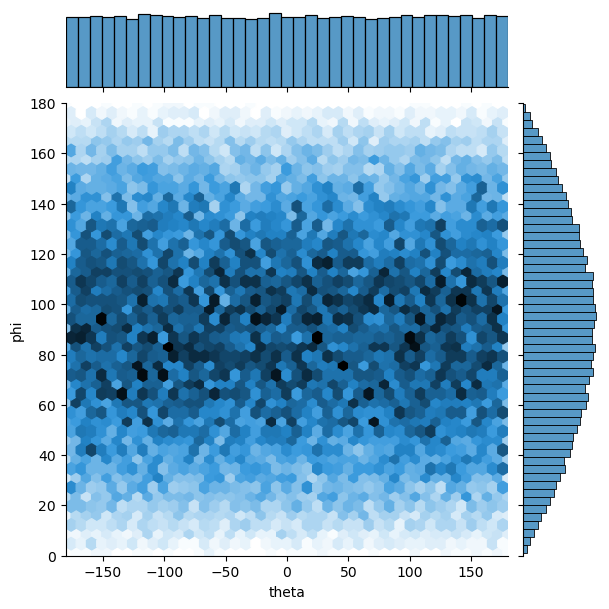

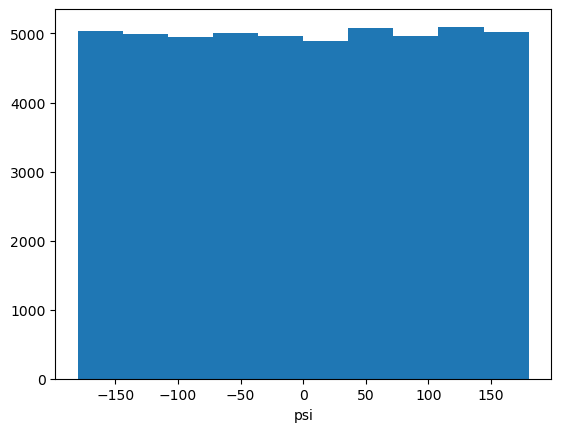

In [21]:
# rotations
analysis.plot_euler(euler[:,0],euler[:,1], euler[:,2])

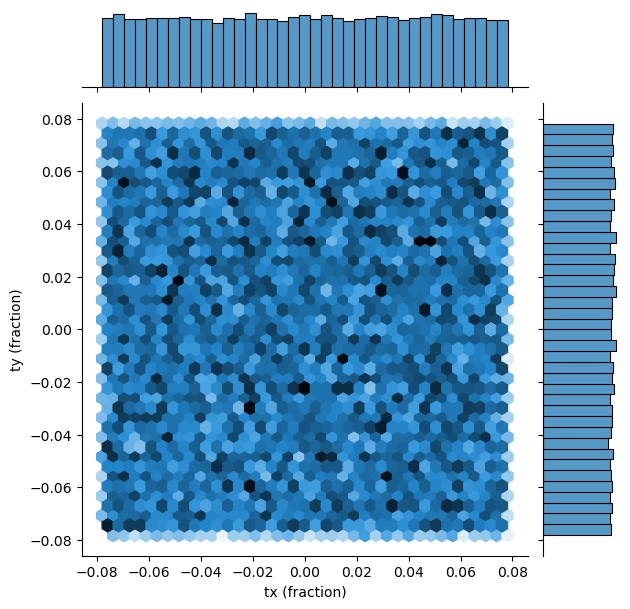

In [22]:
# translations
sns.jointplot(x=trans[:,0],
              y=trans[:,1],
              kind='hex').set_axis_labels('tx (fraction)','ty (fraction)')

### Learning curve

Text(0, 0.5, 'loss')

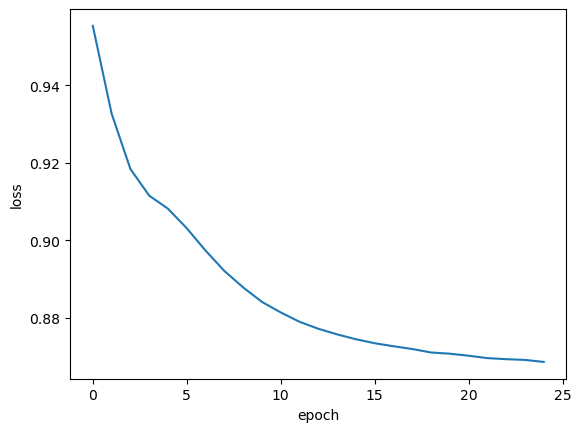

In [23]:
loss = analysis.parse_loss(f'{WORKDIR}/run.log')
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')

### PCA

In [24]:
pc, pca = analysis.run_pca(z)

(INFO) (analysis.py) (19-Apr-23 08:28:08) Explained variance ratio:
(INFO) (analysis.py) (19-Apr-23 08:28:08) [0.39966574 0.33229682 0.11149555 0.08886415 0.03441947 0.0195138
 0.00925145 0.00449302]


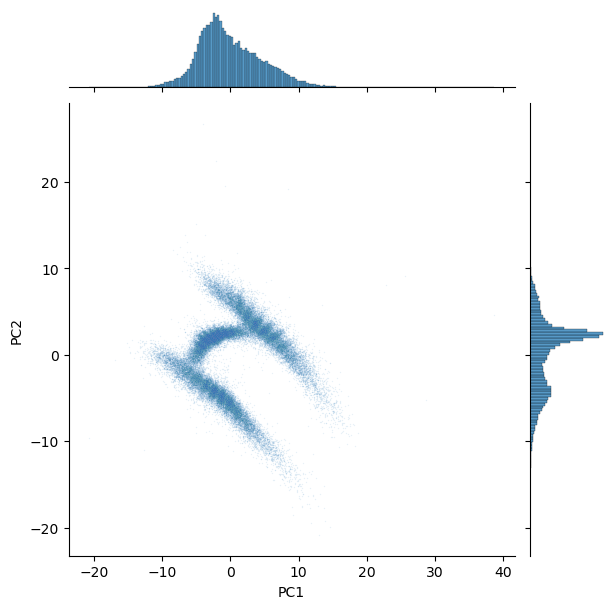

In [25]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], alpha=.1, s=1)
g.set_axis_labels('PC1', 'PC2')

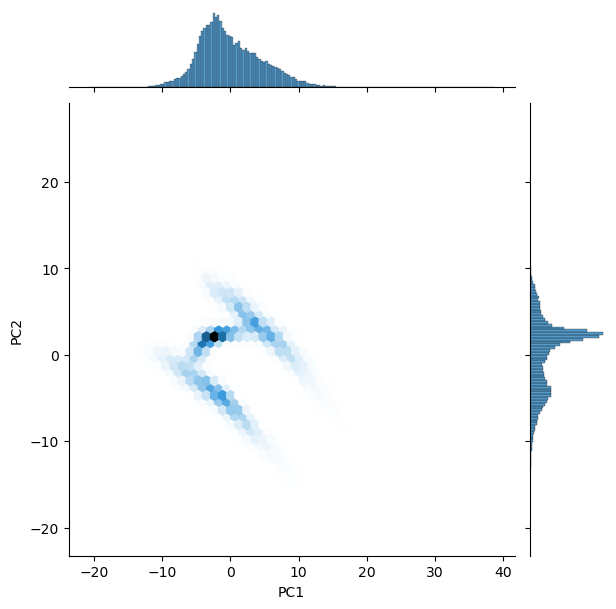

In [26]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], kind='hex')
g.set_axis_labels('PC1', 'PC2')

Text(0, 0.5, 'explained variance')

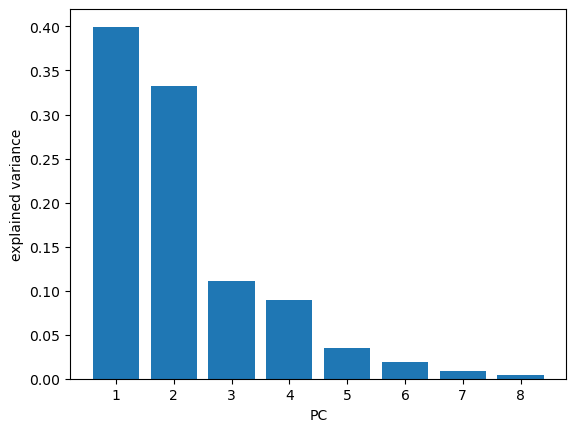

In [27]:
plt.bar(np.arange(z.shape[1])+1,pca.explained_variance_ratio_)
plt.xticks(np.arange(z.shape[1])+1)
plt.xlabel('PC')
plt.ylabel('explained variance')

### UMAP

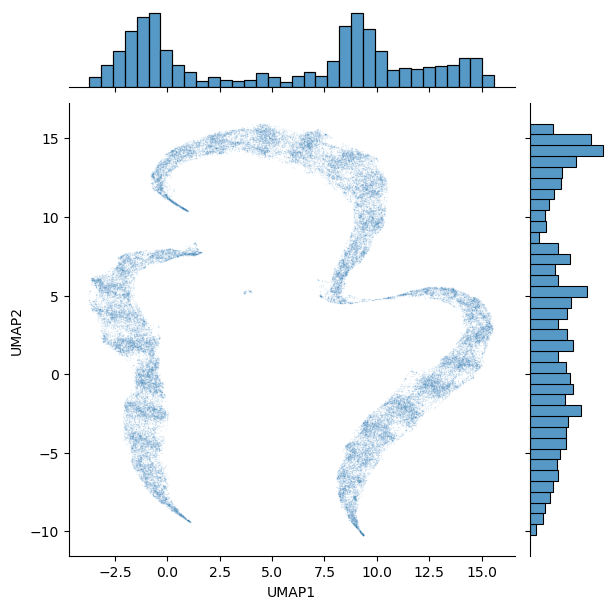

In [28]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], alpha=.1, s=1)
g.set_axis_labels('UMAP1', 'UMAP2')

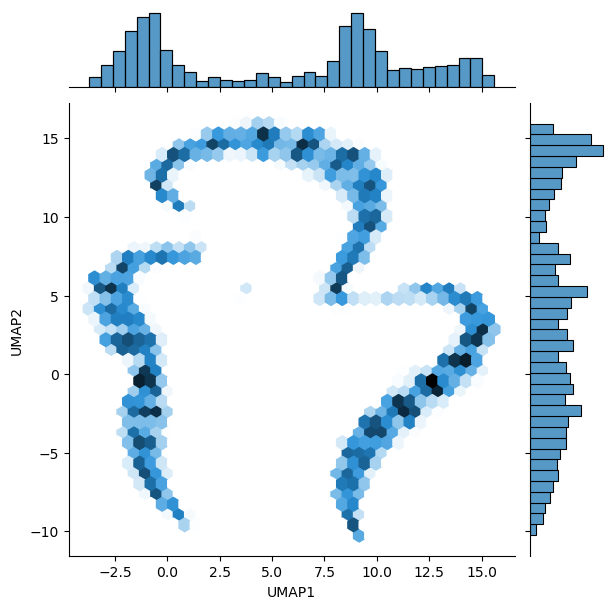

In [29]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], kind='hex')
g.set_axis_labels('UMAP1', 'UMAP2')

# Filter by clustering

Select particles based on k-means cluster labels or GMM cluster labels

### View K-means clusters

In [ ]:
# Optionally, re-run kmeans with the desired number of classes
#K = 20
#kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, K)

Text(0, 0.5, 'PC2')

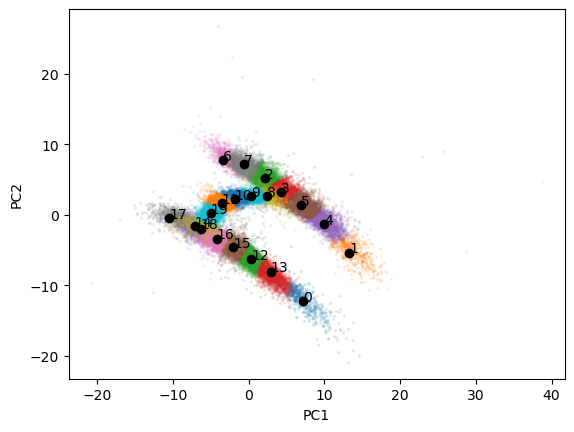

In [30]:
K = len(set(kmeans_labels))
c = pca.transform(kmeans_centers) # transform to view with PCs
analysis.plot_by_cluster(pc[:,0], pc[:,1], K, 
                         kmeans_labels, 
                         centers=c,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

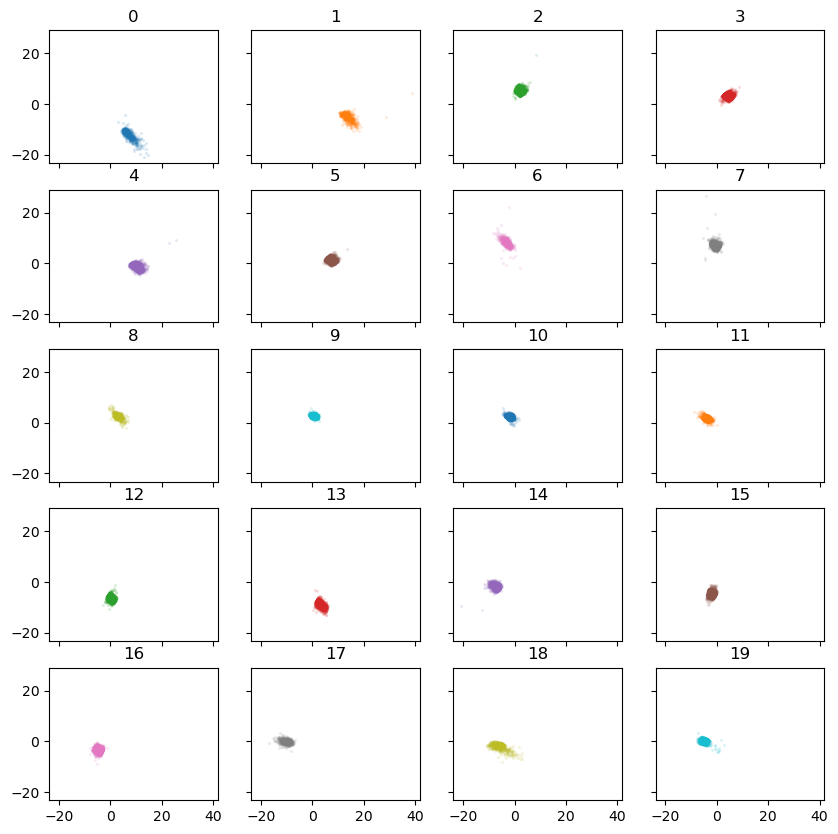

In [31]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], K, 
                            kmeans_labels)

Text(0, 0.5, 'UMAP2')

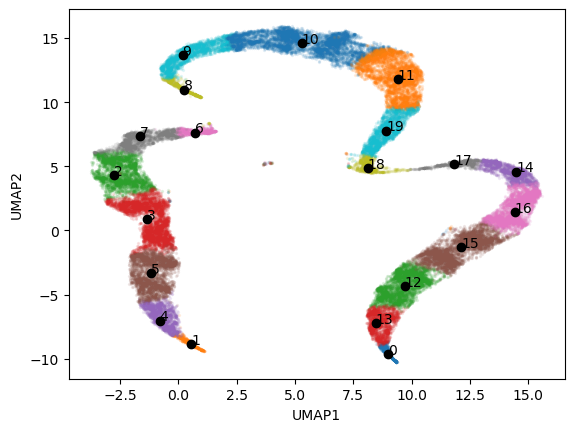

In [32]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], K, 
                         kmeans_labels, 
                         centers_ind=centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

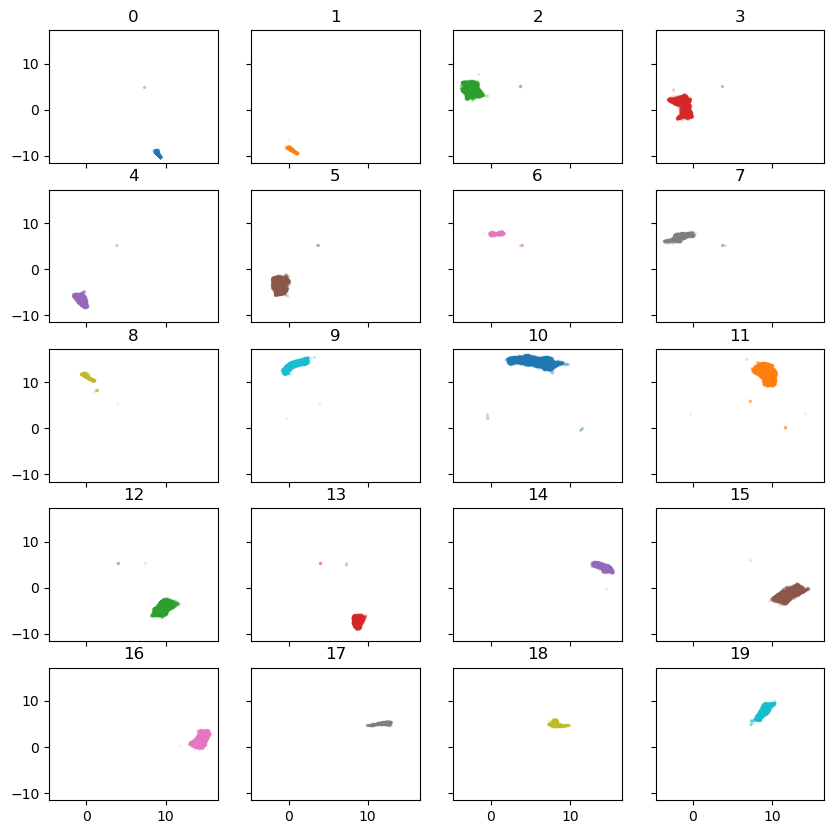

In [33]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], K, 
                            kmeans_labels)

**Select particles based on k-means clustering**

In [34]:
cluster_ids = [0,2] # set clusters to select, 0 and 2 in this example
ind_selected = select_clusters(kmeans_labels, cluster_ids)
ind_selected_not = invert_selection(ind_selected)
print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[    3   178  8284 ... 49997 49998 49999]
Number of selected points:
4118
Number of unselected points:
45882


Text(0, 0.5, 'PC2 (0.33)')

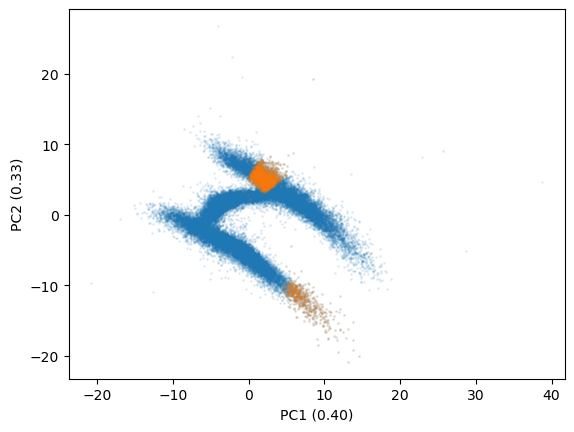

In [35]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

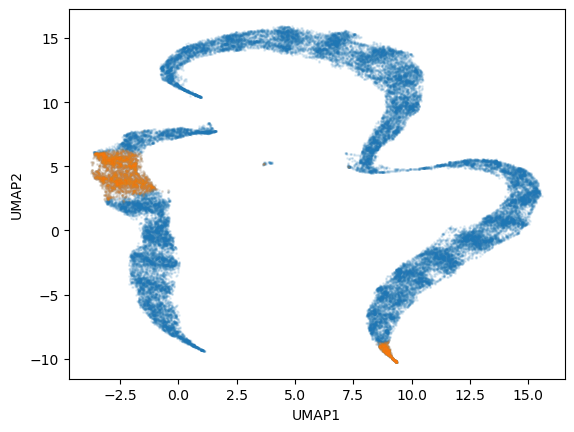

In [36]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

### GMM-clustering

In [37]:
G = 3 # or change to desired cluster number
random_state = np.random.randint(100000) # sample random integer
print(f'Random state: {random_state}')
gmm_labels, gmm_centers = analysis.cluster_gmm(z, G, random_state=random_state)
gmm_centers, gmm_centers_ind = analysis.get_nearest_point(z, gmm_centers)

Random state: 22588


Text(0, 0.5, 'PC2')

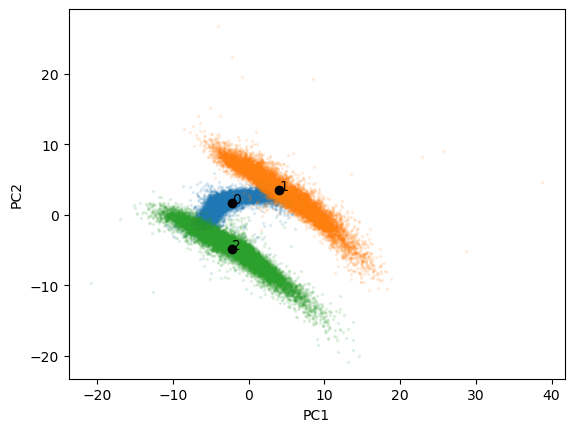

In [38]:
analysis.plot_by_cluster(pc[:,0], pc[:,1], G, 
                         gmm_labels, 
                         centers_ind=gmm_centers_ind,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

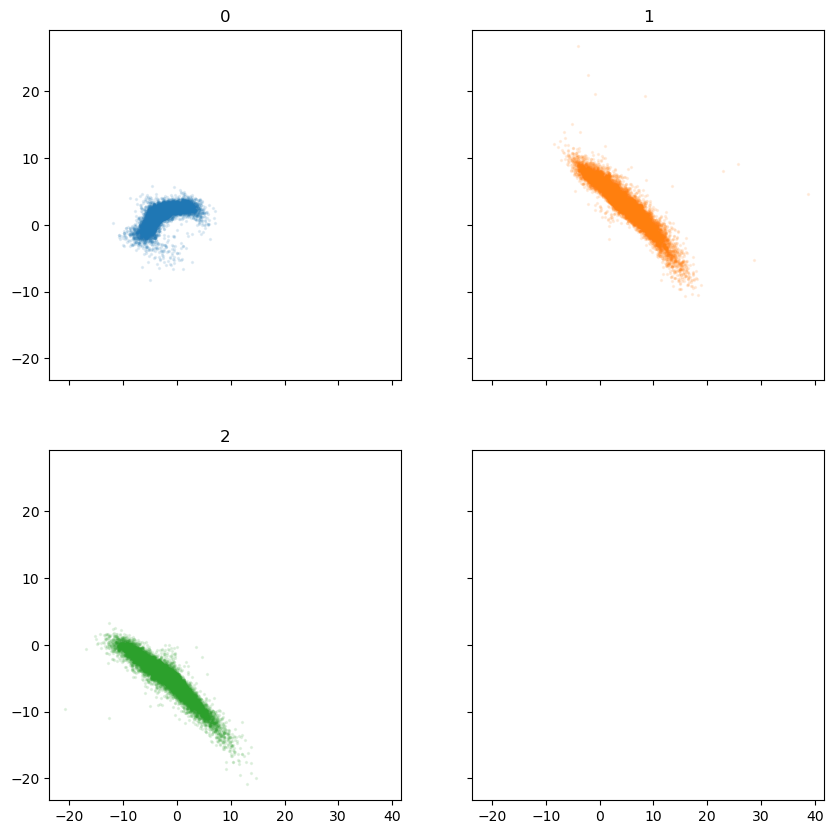

In [39]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], G, gmm_labels)

Text(0, 0.5, 'UMAP2')

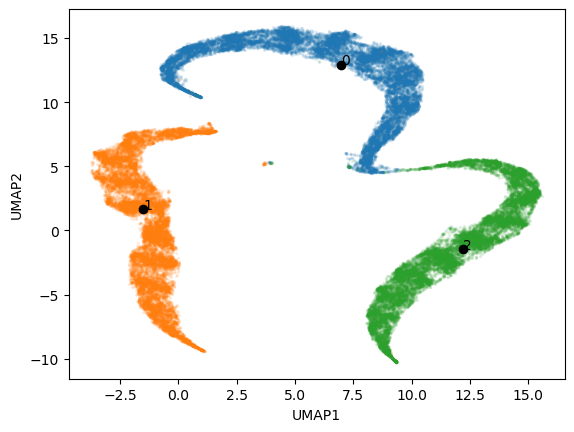

In [40]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], G, 
                         gmm_labels, 
                         centers_ind=gmm_centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

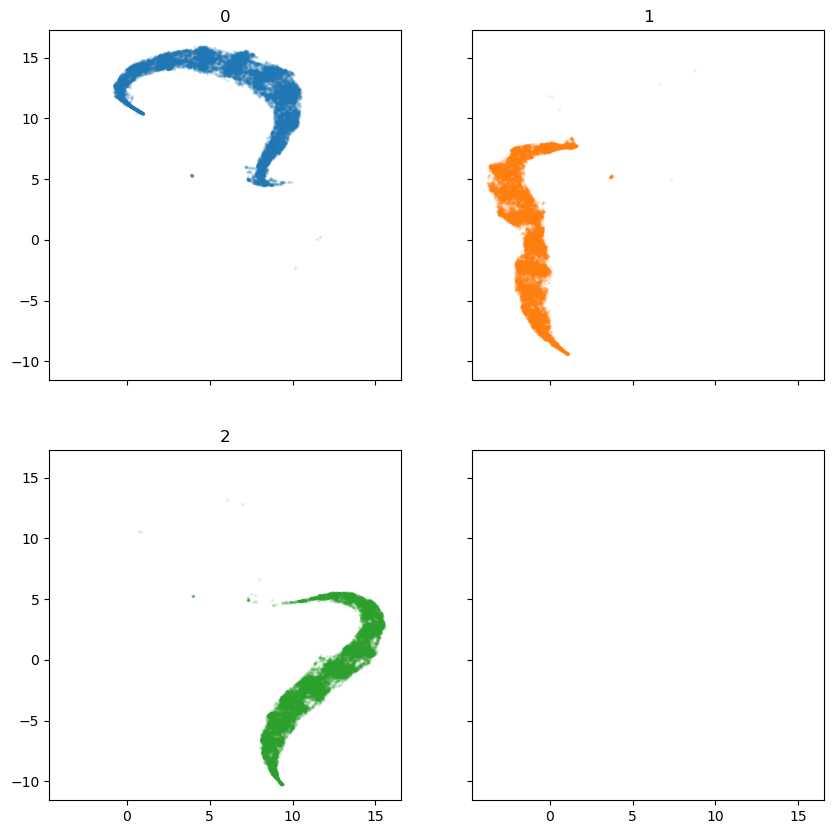

In [41]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], G, gmm_labels)

**Select particles based on GMM-means clustering**

In [42]:
cluster_ids = [0,2] # set clusters to select, 0 and 2 in this example
ind_selected = select_clusters(gmm_labels, cluster_ids)
ind_selected_not = invert_selection(ind_selected)
print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[    3   113  5435 ... 49997 49998 49999]
Number of selected points:
33410
Number of unselected points:
16590


Text(0, 0.5, 'PC2 (0.33)')

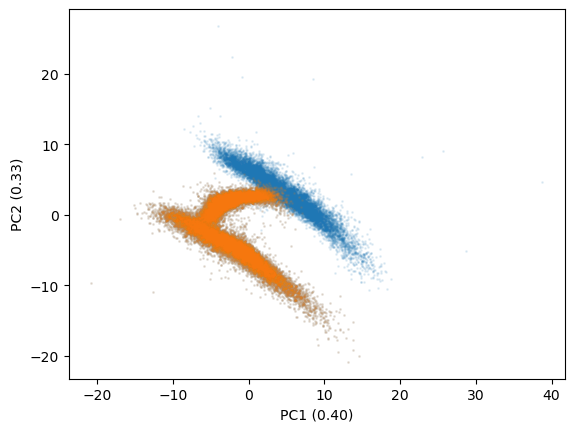

In [43]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

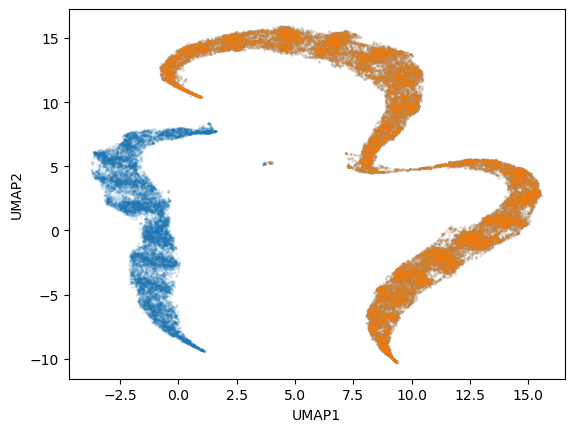

In [44]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Filter outlier particles

In [45]:
# Compute magnitude of latent encodings
znorm = np.sum(z**2,axis=1)**.5

/Users/manifect/opt/miniconda3/envs/cryodrgn-mit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, '||z||')

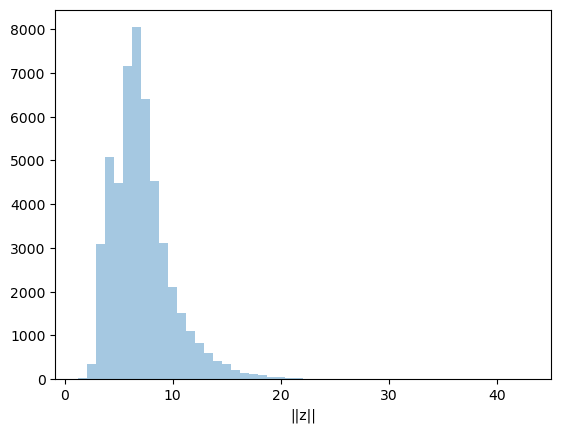

In [46]:
# Distribution of ||z||
sns.distplot(znorm, kde=False)
plt.xlabel('||z||')

In [47]:
# By default, identify particles with ||z|| 2 std deviations above mean
zscore = 2
thresh = znorm.mean()+zscore*znorm.std()
print(f'Mean: {znorm.mean()}, Std: {znorm.std()}, Selected threshold: {thresh}')

Mean: 7.1371049880981445, Std: 2.817002058029175, Selected threshold: 12.771109104156494


In [48]:
ind_outliers = np.where(znorm >= thresh)[0]
ind_outliers_not = invert_selection(ind_outliers)

print('Selected indices:')
print(ind_outliers)
print('Number of selected points:')
print(len(ind_outliers))
print('Number of unselected points:')
print(len(ind_outliers_not))

Selected indices:
[    0     1     2 ... 49997 49998 49999]
Number of selected points:
2260
Number of unselected points:
47740


Text(0.5, 1.0, 'Magnitude of particle latent encodings')

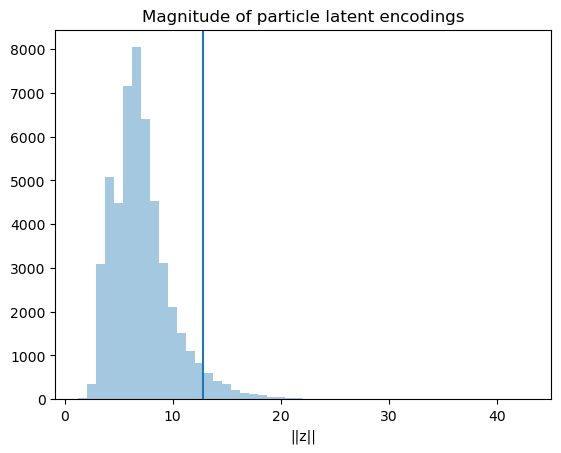

In [49]:
g = sns.distplot(znorm, kde=False)
plt.axvline(x=thresh)
plt.xlabel('||z||')
plt.title('Magnitude of particle latent encodings')

Text(0.5, 1.0, 'Particles with ||z|| > 12.771109104156494')

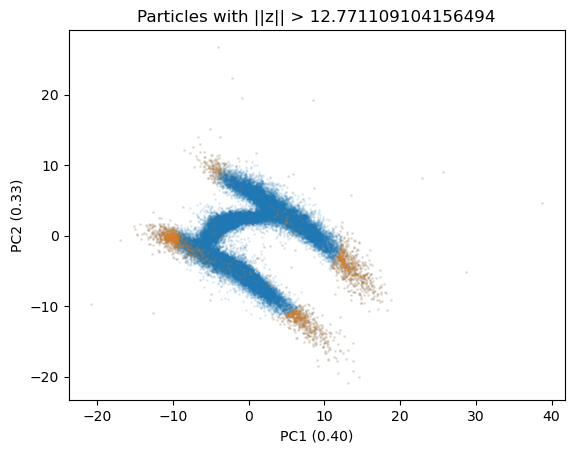

In [50]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_outliers,0], pc[ind_outliers,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))
plt.title(f'Particles with ||z|| > {thresh}')

Text(0.5, 1.0, 'Particles with ||z|| > 12.771109104156494')

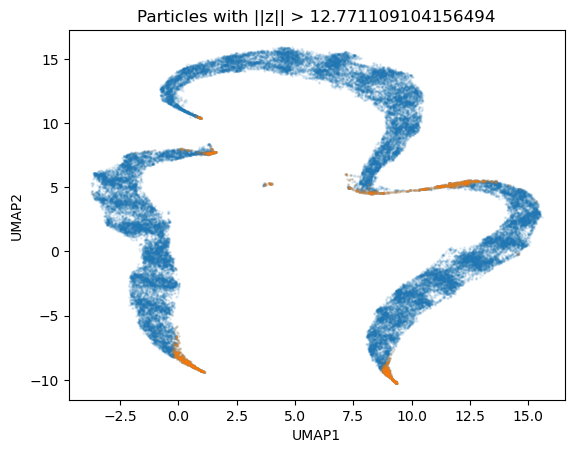

In [51]:
# View UMAP
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_outliers,0], umap[ind_outliers,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title(f'Particles with ||z|| > {thresh}')

In [52]:
# Assign variables for viz/saving cells at the end of the notebook
ind_selected = ind_outliers
ind_selected_not = ind_outliers_not

# Interactive visualization

Interactive visualization of the latent encodings for the trained model. Each point represents a particle image of the dataset. The hover text includes the index of the image in the particle stack. 

In [53]:
# Load data into a pandas dataframe
df = analysis.load_dataframe(z=z, 
                             pc=pc, 
                             euler=euler, 
                             trans=trans, 
                             labels=kmeans_labels, 
                             umap=umap,
                             df1=ctf_params[:,2],
                             df2=ctf_params[:,3],
                             dfang=ctf_params[:,4],
                             phase=ctf_params[:,8],
                             znorm=znorm)
df.head()

,UMAP1,UMAP2,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,z4,z5,z6,z7,df1,df2,dfang,phase,znorm,index
0,1.100240,-9.394914,18.232996,-10.524385,-7.351503,12.821727,-2.779659,-4.126689,-1.492644,-2.424632,...,-1.537606,-9.277155,12.937837,-9.009262,26795.699219,26795.699219,0.0,0.0,26.261856,0
1,0.808845,-9.114173,15.028734,-6.525401,-3.142198,6.193474,-1.817581,-1.959141,-0.236205,-0.692204,...,0.156919,-5.166607,8.147157,-3.808246,16534.980469,16534.980469,0.0,0.0,18.002930,1
2,1.085117,-9.386205,15.193897,-9.552814,-6.237203,9.644857,-4.430701,-2.171740,1.810272,-0.455674,...,-1.179235,-6.663318,12.526093,-6.998057,22468.070312,22468.070312,0.0,0.0,21.922503,2
3,7.292727,4.999832,5.638054,-4.391990,-4.746346,6.693331,8.764259,-3.758227,11.699057,-4.550832,...,12.003534,1.083727,6.254892,-7.013585,15173.799805,15173.799805,0.0,0.0,19.170992,3
4,0.745424,-9.057306,15.491486,-6.765063,-4.251163,7.993871,-1.465634,0.893408,6.540683,1.158677,...,3.557649,-2.289686,10.801411,-7.069595,21441.529297,21441.529297,0.0,0.0,20.554781,4


### Interactive selection

The next two cells contain helper code to select particles using an interactive lasso tool. 

1. In the first cell, select points with the lasso tool. The table widget is dynamically updated with the most recent selection's indices. 
2. Then once you've finalized your selection, **run the next cell** to save the particle indices for downstream analysis/viz.

(Double click to clear selection)

In [54]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df)
VBox((widget,fig,ind_table))

In [55]:
ind_selected = ind_table.data[0].cells.values[0] # save table values
ind_selected = np.array(ind_selected)
ind_selected_not = invert_selection(ind_selected)

print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[    0     1     2 ... 49997 49998 49999]
Number of selected points:
50000
Number of unselected points:
0


Text(0, 0.5, 'PC2 (0.33)')

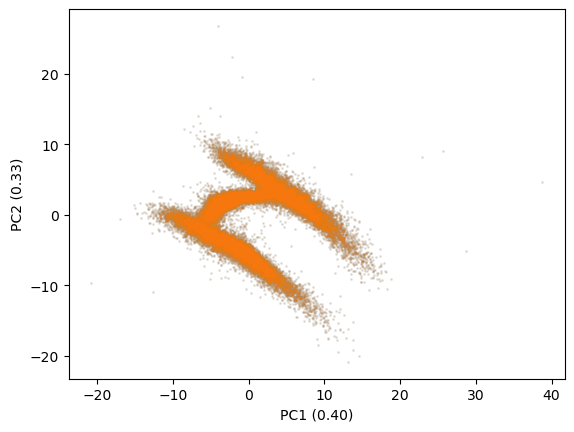

In [56]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

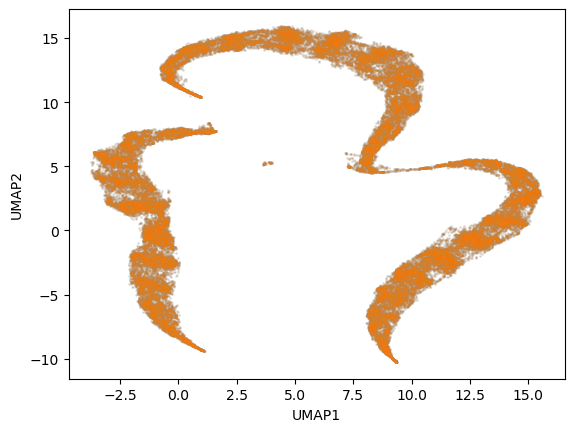

In [57]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# View particles

View images from selected particles

In [58]:
particle_ind = ind_selected # or set to custom selection

In [59]:
# Choose 9 particles to view at random
if len(particle_ind) > 9:
    ind_subset9 = np.random.choice(particle_ind, 9, replace=False)
else: 
    ind_subset9 = particle_ind
print(ind_subset9)

[37675 35196 12496 48241 21257 49917  4303 22703  1975]


Text(0, 0.5, 'UMAP2')

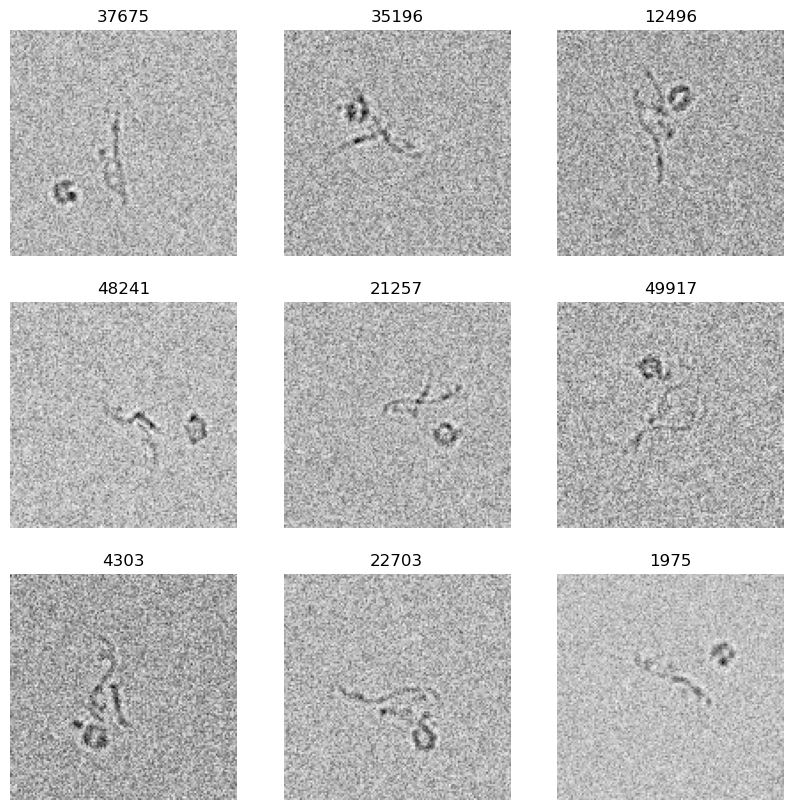

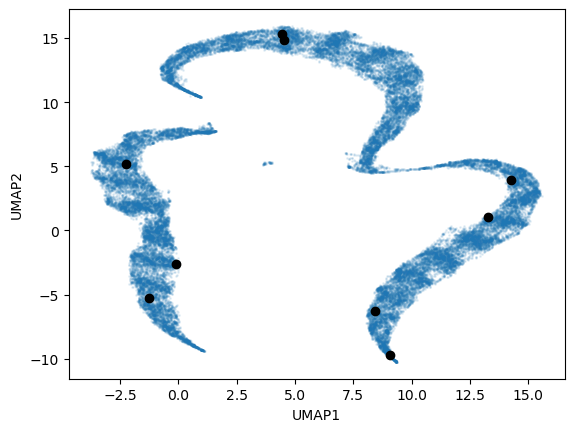

In [60]:
p = [particles[ii].get() for ii in ind_subset9]
_ = analysis.plot_projections(p, ind_subset9)

plt.figure()
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_subset9,0], umap[ind_subset9,1], color='k')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Save selection

Save the particle indices for the selected (`ind_selected`) and unselected particles (`ind_selected_not`) as a .pkl file for downstream processing in cryoDRGN or with other tools.

Rename the paths as desired. Note that the indices will be automatically converted if the current cryoDRGN training run has already been filtered (`ind_orig` loaded in an earlier cell).

In [61]:
# Set selection as either the kept or bad particles (for file naming purposes)
ind_keep = ind_selected # or ind_selected_not
ind_bad = ind_selected_not # or ind_selected

Text(0, 0.5, 'PC2 (0.33)')

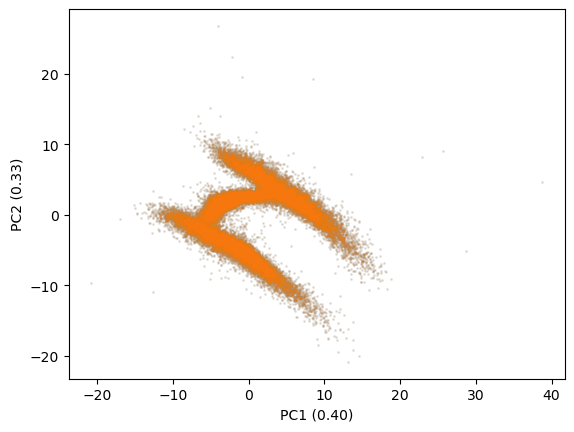

In [62]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_keep,0], pc[ind_keep,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

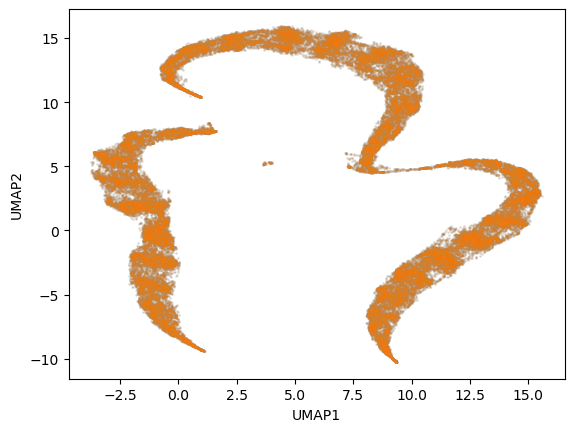

In [63]:
# View UMAP
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_keep,0], umap[ind_keep,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [64]:
print('Kept particle indices:')
print(ind_keep)
print('Number of kept particles:')
print(len(ind_keep))
print('Number of bad particles:')
print(len(ind_bad))

Kept particle indices:
[    0     1     2 ... 49997 49998 49999]
Number of kept particles:
50000
Number of bad particles:
0


In [65]:
# Path to save index .pkl for selected particles
SAVE_PATH = f'{WORKDIR}/ind_keep.{len(ind_keep)}_particles.pkl'
save_selection(SAVE_PATH, ind_keep)

Wrote /Users/manifect/Desktop/Yaozhigang project/temp_result/03_cryodrgn128-cooperative/ind_keep.50000_particles.pkl


In [66]:
# Path to save index .pkl for non-selected particles
SAVE_PATH = f'{WORKDIR}/ind_bad.{len(ind_bad)}_particles.pkl'
save_selection(SAVE_PATH, ind_bad)

Wrote /Users/manifect/Desktop/Yaozhigang project/temp_result/03_cryodrgn128-cooperative/ind_bad.0_particles.pkl
